# "customer-churn-prediction-2020"

- toc:true
- branch: master
- badges: true
- comments: true
- author: hayley
- layout: post 
- categories: [ml project]
- date : 2022-11-07 17:05:00

In [152]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 

In [419]:
submission = pd.read_csv('https://raw.githubusercontent.com/minaahayley/kaggle/main/customer-churn-prediction-2020/data/sampleSubmission.csv')
test = pd.read_csv('https://raw.githubusercontent.com/minaahayley/kaggle/main/customer-churn-prediction-2020/data/test.csv')
train = pd.read_csv('https://raw.githubusercontent.com/minaahayley/kaggle/main/customer-churn-prediction-2020/data/train.csv')

In [420]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4250 entries, 0 to 4249
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   state                          4250 non-null   object 
 1   account_length                 4250 non-null   int64  
 2   area_code                      4250 non-null   object 
 3   international_plan             4250 non-null   object 
 4   voice_mail_plan                4250 non-null   object 
 5   number_vmail_messages          4250 non-null   int64  
 6   total_day_minutes              4250 non-null   float64
 7   total_day_calls                4250 non-null   int64  
 8   total_day_charge               4250 non-null   float64
 9   total_eve_minutes              4250 non-null   float64
 10  total_eve_calls                4250 non-null   int64  
 11  total_eve_charge               4250 non-null   float64
 12  total_night_minutes            4250 non-null   f

In [421]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750 entries, 0 to 749
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             750 non-null    int64  
 1   state                          750 non-null    object 
 2   account_length                 750 non-null    int64  
 3   area_code                      750 non-null    object 
 4   international_plan             750 non-null    object 
 5   voice_mail_plan                750 non-null    object 
 6   number_vmail_messages          750 non-null    int64  
 7   total_day_minutes              750 non-null    float64
 8   total_day_calls                750 non-null    int64  
 9   total_day_charge               750 non-null    float64
 10  total_eve_minutes              750 non-null    float64
 11  total_eve_calls                750 non-null    int64  
 12  total_eve_charge               750 non-null    flo

# Feature Engineering

## 변수끼리의 상관관계 

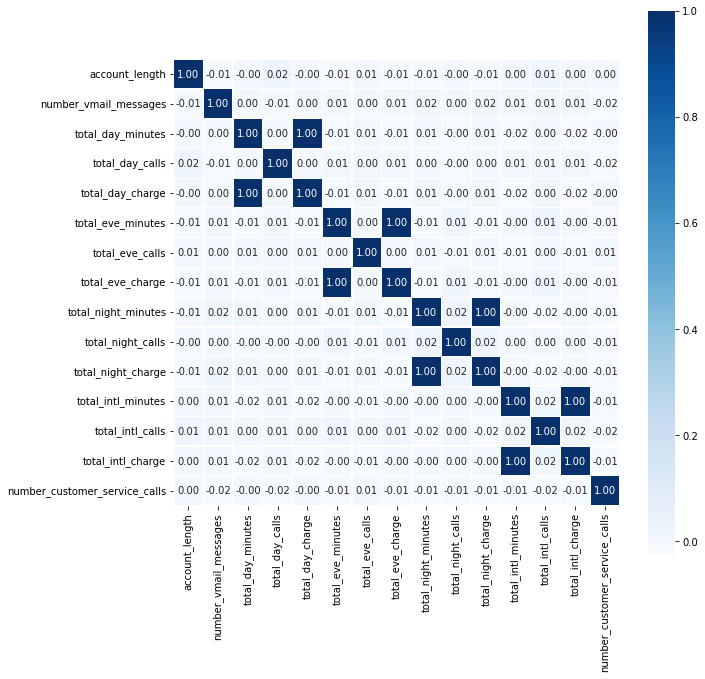

In [422]:
plt.figure(figsize=(10,10))

# target을 제외한 변수끼리의 상관관계 
corr_data = train.drop('churn', axis=1)

sns.heatmap(corr_data.corr()
			      , linewidths = 0.1
            , square = True
            , annot = True
            , fmt = '.2f'
            , cmap='Blues')

In [423]:
# Churn 비율 살펴보기 
train['churn'].value_counts(normalize=True)

no     0.859294
yes    0.140706
Name: churn, dtype: float64

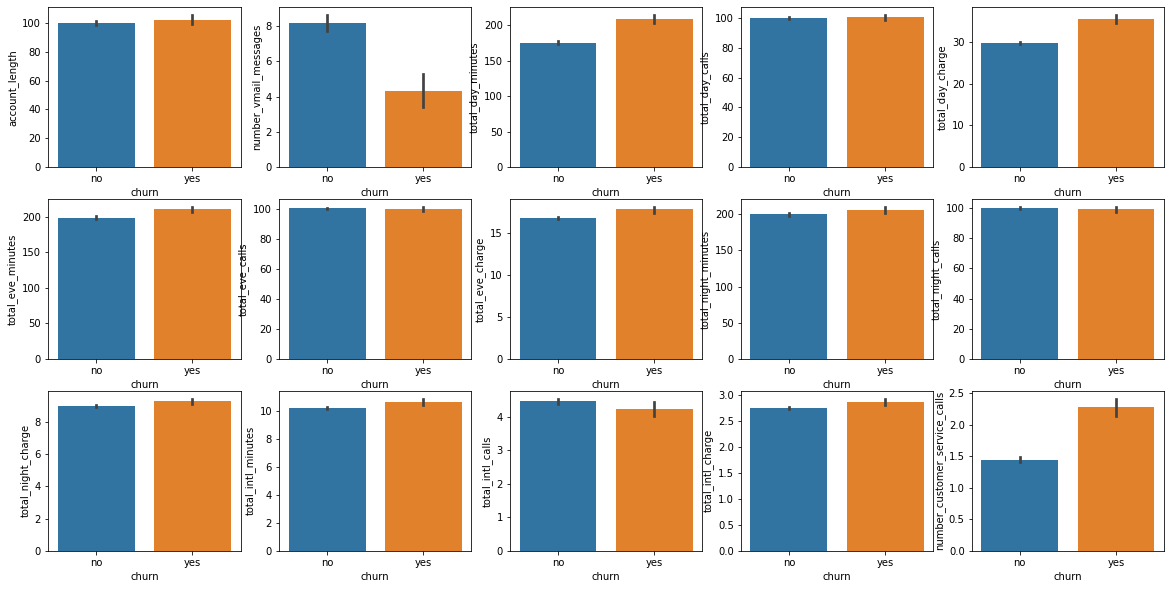

In [424]:
fig, axs = plt.subplots(figsize=(20, 10), ncols=5, nrows=3)
features = train.describe().columns 

for i, feature in enumerate(features): 
    row = int(i/5)
    col = i%5
    sns.barplot(x='churn', y=feature, data=train, ax=axs[row][col])

## 데이터 분포도 
* 피처 데이터 세트도 지나치게 왜곡된 피처가 존재할 경우 회귀 예측 성능을 저하시킬 수 있다.
* skew() 함수를 이용하여 모든 숫자형 피처의 왜곡 정도를 확인하자.
  * 1이상인 경우 왜곡 정도 높음
  * 왜곡 정도가 높은 피처를 로그 변환 후, 원핫인코딩을 해야 함

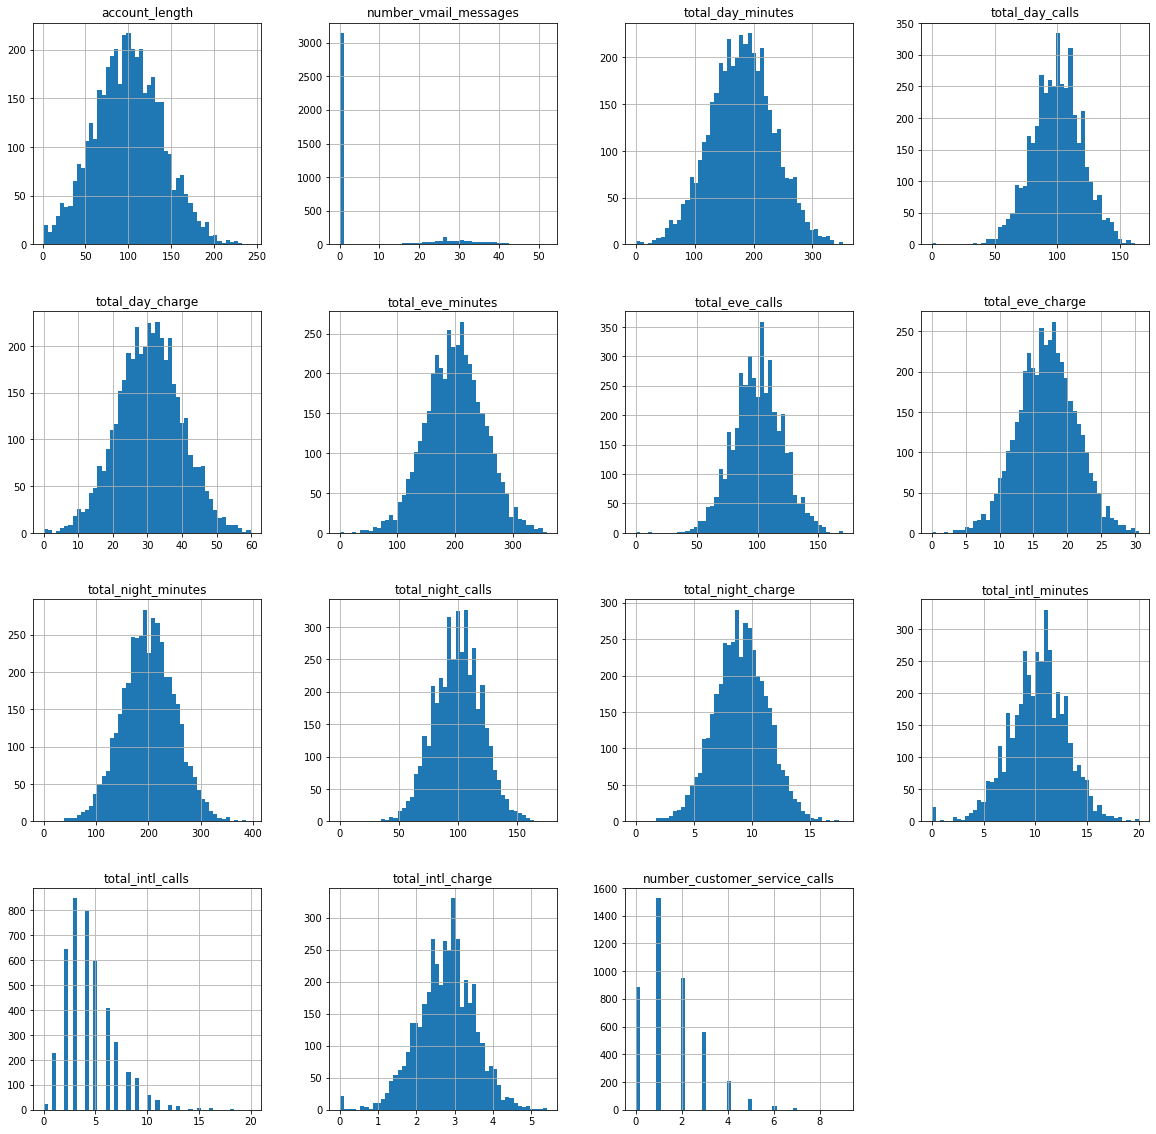

In [425]:
train.hist(figsize=(20, 20), bins=50)
plt.show()

In [426]:
from scipy.stats import skew 

# 숫자형 피처의 컬럼 index 추출 
feature_index = train.dtypes[train.dtypes != 'object'].index 
 
skew_features = train[feature_index].apply(lambda x : skew(x))

# skew(왜곡) 정도가 1이상인 컬럼만 추출 
skew_features_top = skew_features[skew_features > 1].sort_values(ascending=False)
skew_features_top

number_vmail_messages            1.372606
total_intl_calls                 1.359642
number_customer_service_calls    1.082309
dtype: float64

In [427]:
# 로그 변환 
train[skew_features_top.index] = np.log1p(train[skew_features_top.index])
test[skew_features_top.index] = np.log1p(test[skew_features_top.index])

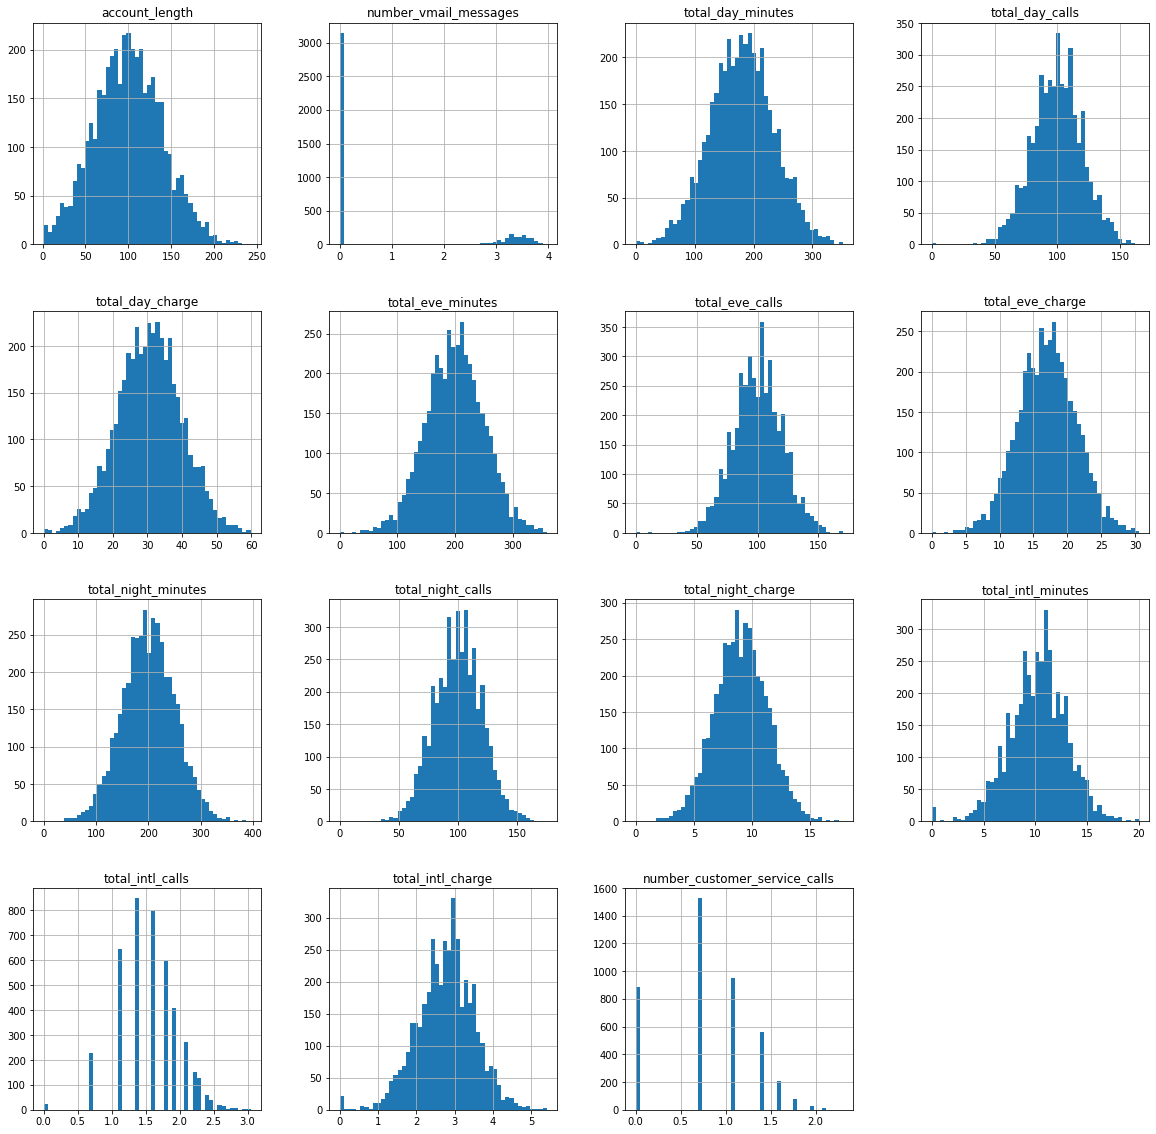

In [428]:
train.hist(figsize=(20, 20), bins=50)
plt.show()

## 카테고리컬 인코딩 
* 원핫 인코딩 
  * 범주형 변수에 순서가 없다 
  * 범주의 종류가 별로 없어서 효과적으로 원 핫 인코딩의 적용이 가능할 때 
* 레이블 인코딩 
  * 범주형 변수가 순서가 있다(초, 중, 고등학교) 
  * 범주의 종류가 꽤 많아서 원 핫 인코딩으로 다루기 힘들 때 

In [429]:
# 레이블 인코딩 
train['state'] = pd.Categorical(train['state']).codes 
train['area_code'] = pd.Categorical(train['area_code']).codes 
train['international_plan'] = pd.Categorical(train['international_plan']).codes 
train['voice_mail_plan'] = pd.Categorical(train['voice_mail_plan']).codes 

test['state'] = pd.Categorical(test['state']).codes 
test['area_code'] = pd.Categorical(test['area_code']).codes 
test['international_plan'] = pd.Categorical(test['international_plan']).codes 
test['voice_mail_plan'] = pd.Categorical(test['voice_mail_plan']).codes 

In [430]:
# Churn 컬럼을 숫자로 바꾸기 
train['churn'] = train['churn'].apply(lambda x : 1 if x == 'yes' else 0)

In [431]:
train['churn'].value_counts()

0    3652
1     598
Name: churn, dtype: int64

# 모델링 

## 랜덤 포레스트

In [432]:
#submission을 위해 test_id는 별도로 저장
test_id = test['id'] 

In [433]:
# X, y 설정 
X = train.drop('churn', axis=1)
y = train['churn']

In [434]:
# 학습, 훈련 데이터 분할 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [435]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=1000)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1000)

In [436]:
from sklearn.metrics import accuracy_score

print(model.__class__.__name__,': training set에서의 성능')
y_train_pred = rf_clf.predict(X_train)
print(accuracy_score(y_train, y_train_pred))

print(model.__class__.__name__,': test set에서의 성능')
y_test_pred = rf_clf.predict(X_test)
print(accuracy_score(y_test, y_test_pred))

LogisticRegression : training set에서의 성능
1.0
LogisticRegression : test set에서의 성능
0.9564705882352941


In [437]:
# 최종 예측 
y_test_pred = rf_clf.predict(test.drop('id', axis=1))

In [438]:
# 제출 파일 생성 
df = pd.DataFrame()
df['id'] = test_id
df['churn'] = pd.Series(y_test_pred)
df['churn'] = df['churn'].apply(lambda x : 'yes' if x == 1 else 'no')
df.to_csv('submission.csv', index=False)

* public score : 0.96888

## 트리 회귀와 로지스틱 회귀  

In [439]:
def get_model_predict(model, X_train, X_test, y_train, y_test): 
  model.fit(X_train, y_train)
  
  print('\n', model.__class__.__name__)
  print('training set에서의 성능')
  y_train_pred = model.predict(X_train)
  print(accuracy_score(y_train, y_train_pred))

  print('test set에서의 성능')
  y_test_pred = model.predict(X_test)
  print(accuracy_score(y_test, y_test_pred))

In [440]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier 
from lightgbm import LGBMClassifier 
from sklearn.linear_model import LogisticRegression

# 평가 수행 
rf_clf = RandomForestClassifier(n_estimators=200)
gbm_clf = GradientBoostingClassifier(n_estimators=200)
xgb_clf = XGBClassifier(n_estimators=200, learning_rate=0.05, colsample_bytree=0.5, subsample=0.8)
lgbm_clf = LGBMClassifier(n_estimators=200, learning_rate=0.05, num_leaves=4,
                          subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
lr_reg = LogisticRegression(solver='liblinear', max_iter=200)

for model in [rf_clf, gbm_clf, xgb_clf, lgbm_clf, lr_reg]: 
    # XGBoost의 경우 DataFrame이 입력될 경우 버전에 따라 오류 발생 가능. naddray로 변환 
    get_model_predict(model, X_train.values, X_test.values, y_train.values, y_test.values)


 RandomForestClassifier
training set에서의 성능
1.0
test set에서의 성능
0.9564705882352941

 GradientBoostingClassifier
training set에서의 성능
0.9779411764705882
test set에서의 성능
0.96

 XGBClassifier
training set에서의 성능
0.9658823529411765
test set에서의 성능
0.9458823529411765

 LGBMClassifier
training set에서의 성능
0.9473529411764706
test set에서의 성능
0.9341176470588235

 LogisticRegression
training set에서의 성능
0.875
test set에서의 성능
0.8576470588235294


In [441]:
# 최종 예측 
y_test_pred = xgb_clf.predict(test.drop('id', axis=1).values)

In [442]:
# 제출 파일 생성 
df = pd.DataFrame()
df['id'] = test_id
df['churn'] = pd.Series(y_test_pred)
df['churn'] = df['churn'].apply(lambda x : 'yes' if x == 1 else 'no')
df.to_csv('submission.csv', index=False)

* public score : 0.96888